<h1 align=center><font size = 5>Capstone Project - The Battle of Neighbourhoods</font></h1>

## Introduction

Singapore is a country with a very diverse culture. It has been recognized as a city with “best investment potential” and world’s most competitive economy, as per Wikipedia, and is a home to 5.6 million residents. Singaporeans love to eat. Whenever a new food place would open up, a queue is expected that could last for hours.

A lot of businesses, especially food places, open up regularly. Unfortunately, some of them cannot sustain the business after the initial hype has mellowed down. It would be interesting to get a feel of the trending markets and how saturated the market is for a particular neighbourhood, in Singapore’s case, a particular sub-zone. The aim of this project is identify new market opportunities/ potential businesses in Singapore using Four Square location data. 

This project would utilize Four Square data to identify the popular venues in Singapore, what businesses are already available and how saturated the market is. The target audience would be the potential investors.

## Data

I will be using Singapore boundary data to identify the regions and sub-zones in Singapore. The source of the data is from https://data.gov.sg/ I have downloaded the data for the master plan subzone boundary for 2014 to get the divisions of the zones. The files come in kml and shp formats, so will need to be converted first before I can use them in my analysis. I used https://mygeodata.cloud/converter/kml-to-csv and converted them to a CSV file. 

First, import all the libraries.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

#for clustering
from sklearn.cluster import KMeans 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

Read the csv data. I already uploaded the data to github for ease of access.

In [2]:
filename = "https://raw.githubusercontent.com/velvetliz87/Coursera_Capstone/master/SG_subzone.csv"

In [3]:
df = pd.read_csv(filename)
df.head()

,X,Y,Name,Region Name,Planning Area Name,Region Code,Central Area Indicator,Subzone Code,Planning Area Code
0,103.822322,1.286512,HENDERSON HILL,CENTRAL REGION,BUKIT MERAH,CR,N,BMSZ08,BM
1,103.817180,1.287737,REDHILL,CENTRAL REGION,BUKIT MERAH,CR,N,BMSZ03,BM
2,103.809556,1.287683,ALEXANDRA HILL,CENTRAL REGION,BUKIT MERAH,CR,N,BMSZ07,BM
3,103.844945,1.289751,CLARKE QUAY,CENTRAL REGION,SINGAPORE RIVER,CR,Y,SRSZ02,SR
4,103.798388,1.288607,QUEENSWAY,CENTRAL REGION,QUEENSTOWN,CR,N,QTSZ07,QT


Remove the other fields that are not needed like Planning area name, region code, subzone code and planning area code

In [4]:
df.drop(['Planning Area Name','Region Code','Subzone Code','Planning Area Code'], axis=1, inplace=True)

Rename the Name column to Subzone to make it more understandable and the X and Y to Longitude and Latitude, respectively

In [5]:
df.rename(columns={'X':'Longitude', 'Y':'Latitude','Name':'Subzone'}, inplace=True)
df.head()


,Longitude,Latitude,Subzone,Region Name,Central Area Indicator
0,103.822322,1.286512,HENDERSON HILL,CENTRAL REGION,N
1,103.817180,1.287737,REDHILL,CENTRAL REGION,N
2,103.809556,1.287683,ALEXANDRA HILL,CENTRAL REGION,N
3,103.844945,1.289751,CLARKE QUAY,CENTRAL REGION,Y
4,103.798388,1.288607,QUEENSWAY,CENTRAL REGION,N


The sub-zones fall under 5 regions, namely: Central Region, West Region, North-East Region, East Region and North Region. There is also a field called Central Area Indicator, which indicates whether the sub-zone can be found in the central area. This would be useful if we are only interested in the Sub-zones that belong to the central districts.

#### Use geopy library to get the Latitude and longitude of Singapore.

Define a user_agent to define an instance of the geocoder. I use sg_explorer as defined below:

In [6]:
address = 'Singapore, Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.3408528, 103.878446863736.


#### Create a map of Singapore with the sub-zones superimposed

In [7]:
# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, region, zone in zip(df['Latitude'], df['Longitude'], df['Region Name'], df['Subzone']):
    label = '{}, {}'.format(zone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

Let's analyze first the sub-zones within the Central Area. For this one, we can use the Central Area indicator and create a new data frame containing only those sub-zones with Central Area indicator = 'Y'

In [8]:
central = df[df['Central Area Indicator'] == 'Y'].reset_index(drop=True)
central.head()

,Longitude,Latitude,Subzone,Region Name,Central Area Indicator
0,103.844945,1.289751,CLARKE QUAY,CENTRAL REGION,Y
1,103.843342,1.274116,ANSON,CENTRAL REGION,Y
2,103.837635,1.293569,INSTITUTION HILL,CENTRAL REGION,Y
3,103.859296,1.271357,STRAITS VIEW,CENTRAL REGION,Y
4,103.848562,1.278497,CECIL,CENTRAL REGION,Y


In [9]:
#check how many sub-zones are part of the Central Area
central.shape

(46, 5)

Now, to visualize the Central Area in a map:

In [10]:
# create map of Central Area using latitude and longitude values
map_central = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, region, zone in zip(central['Latitude'], df['Longitude'], df['Region Name'], df['Subzone']):
    label = '{}, {}'.format(zone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_central)  
    
map_central

Next step is exploring the Central Area using Foursquare API

#### Define Foursquare criteria and version

In [11]:
CLIENT_ID = 'F2R520QHLU0J1BI04AVCKQNKV1EAW1NX1MJQTKGMZE0CIQTZ' # your Foursquare ID
CLIENT_SECRET = 'U4ZLNVLE42DHCP2RIUTMV2XZBRV4L4KCA2AU3QYG0DU1TTP2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F2R520QHLU0J1BI04AVCKQNKV1EAW1NX1MJQTKGMZE0CIQTZ
CLIENT_SECRET:U4ZLNVLE42DHCP2RIUTMV2XZBRV4L4KCA2AU3QYG0DU1TTP2


#### Exploring the first sub-zone in Central Area

In [12]:
central.loc[0,"Subzone"]

'CLARKE QUAY'

Getting Clarke Quay's (CQ) latitude and longitude:

In [13]:
zone_latitude = central.loc[0, 'Latitude'] # zone's latitude value
zone_longitude = central.loc[0, 'Longitude'] # zone's longitude value

zone_name = central.loc[0, 'Subzone'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(zone_name, 
                                                               zone_latitude, 
                                                               zone_longitude))

Latitude and longitude values of CLARKE QUAY are 1.289750772, 103.8449452.


Clarke Quay (CQ) is one of the most popular spots in Singapore. It is where the Singapore River is and is also close to Central Business District. It has plenty of restaurants as well as hotels and bar. So, I wanted to look at the top 100 most popular venues in Clarke Quay within 1km.

First, define the URL to GET request: 

In [14]:
#define the linit of the number of venues returned by Foursquare API (100 for top 100 venues)
LIMIT = 100

#define the radius (1 KM)
radius = 1000

#create the URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    zone_latitude, 
    zone_longitude, 
    radius, 
    LIMIT)

#display URL
url 


'https://api.foursquare.com/v2/venues/explore?&client_id=F2R520QHLU0J1BI04AVCKQNKV1EAW1NX1MJQTKGMZE0CIQTZ&client_secret=U4ZLNVLE42DHCP2RIUTMV2XZBRV4L4KCA2AU3QYG0DU1TTP2&v=20180605&ll=1.289750772,103.8449452&radius=1000&limit=100'

Send the GET request and look at the results

In [15]:
results = requests.get(url).json()
#results

Get the categories using the get_category_type function from the previous Foursquare lab

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Looking at json file to get the venues and the corresponding categories and transform into a pandas dataframe

In [17]:
pop_venues = results['response']['groups'][0]['items']
    
#flatten JSON    
nearby_venues = json_normalize(pop_venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Clarke Quay Riverside,Waterfront,1.289661,103.846464
1,28 HongKong Street,Cocktail Bar,1.287815,103.846789
2,Swissôtel Merchant Court,Hotel,1.288434,103.845674
3,Nirai Kanai Okinawan Restaurant,Japanese Restaurant,1.291493,103.845279
4,nomVnom,Vegetarian / Vegan Restaurant,1.288977,103.846930


Display the number of venues returned by Foursquare

In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Display the number of unique categories returned fo CQ:

In [19]:
print('There are {} unique categories.'.format(len(nearby_venues['categories'].unique())))

There are 58 unique categories.


#### Explore and compare all the sub-zones in the Central Area of Singapore

First, we need to define a function to get the nearby venues for the sub-zones in the Central Area in Singapore within 500 meter radius

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subzone', 
                  'Subzone Latitude', 
                  'Subzone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that the function has been defined to extract the popular venues for each sub-zone, we now run the function to create a new data frame called subzone_venue

In [21]:
subzone_venue = getNearbyVenues(names=central['Subzone'],
                                   latitudes=central['Latitude'],
                                   longitudes=central['Longitude']
                                  )

CLARKE QUAY
ANSON
INSTITUTION HILL
STRAITS VIEW
CECIL
PHILLIP
RAFFLES PLACE
BAYFRONT SUBZONE
BENCOOLEN
BRAS BASAH
CHINA SQUARE
BUGIS
MACKENZIE
PATERSON
TANJONG PAGAR
CLIFFORD PIER
ORANGE GROVE
LITTLE INDIA
KAMPONG GLAM
SELEGIE
ROCHOR CANAL
FARRER PARK
MARINA SOUTH
MAXWELL
PEARL'S HILL
BOAT QUAY
ROBERTSON QUAY
CENTRAL SUBZONE
PEOPLE'S PARK
CHINATOWN
CITY HALL
MARINA CENTRE
OXLEY
ONE TREE HILL
SOMERSET
LEONIE HILL
SUNGEI ROAD
DHOBY GHAUT
VICTORIA
CAIRNHILL
FORT CANNING
BOULEVARD
MOUNT EMILY
TANGLIN
NEWTON CIRCUS
GOODWOOD PARK


To check the number of sub-zones returned and the details:

In [22]:
print (subzone_venue.shape)
subzone_venue.head()

(3112, 7)


,Subzone,Subzone Latitude,Subzone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CLARKE QUAY,1.289751,103.844945,Clarke Quay Riverside,1.289661,103.846464,Waterfront
1,CLARKE QUAY,1.289751,103.844945,Swissôtel Merchant Court,1.288434,103.845674,Hotel
2,CLARKE QUAY,1.289751,103.844945,Nirai Kanai Okinawan Restaurant,1.291493,103.845279,Japanese Restaurant
3,CLARKE QUAY,1.289751,103.844945,Zouk,1.290995,103.845947,Nightclub
4,CLARKE QUAY,1.289751,103.844945,Jumbo Seafood Restaurant,1.288983,103.844812,Seafood Restaurant


Display how many venues were returned for each sub-zone

In [23]:
subzone_venue.groupby('Subzone').count()

,Subzone Latitude,Subzone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Subzone,,,,,,
ANSON,72,72,72,72,72,72
BAYFRONT SUBZONE,62,62,62,62,62,62
BENCOOLEN,65,65,65,65,65,65
BOAT QUAY,100,100,100,100,100,100
BOULEVARD,100,100,100,100,100,100
BRAS BASAH,73,73,73,73,73,73
BUGIS,100,100,100,100,100,100
CAIRNHILL,72,72,72,72,72,72
CECIL,100,100,100,100,100,100


Display the number of unique categories from the venues returned

In [24]:
print('There are {} unique categories.'.format(len(subzone_venue['Venue Category'].unique())))

There are 232 unique categories.


## Analyze each sub-zone

Do one-hot encoding to determine whether a sub-zone has a particular category

In [25]:
# one hot encoding
central_onehot = pd.get_dummies(subzone_venue[['Venue Category']], prefix="", prefix_sep="")

# add subzones column back to dataframe
central_onehot['Subzone'] = subzone_venue['Subzone'] 

# move subzone column to the first column
fixed_columns = [central_onehot.columns[-1]] + list(central_onehot.columns[:-1])
central_onehot = central_onehot[fixed_columns]

central_onehot.head()

,Subzone,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,CLARKE QUAY,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CLARKE QUAY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CLARKE QUAY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CLARKE QUAY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CLARKE QUAY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
central_onehot.shape

(3112, 233)

Group the rows by sub-zone and take the mean frequency of each category

In [27]:
central_grouped = central_onehot.groupby('Subzone').mean().reset_index()
central_grouped

,Subzone,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ANSON,0.000000,0.013889,0.00,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,...,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,BAYFRONT SUBZONE,0.016129,0.000000,0.00,0.016129,0.016129,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.048387,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,BENCOOLEN,0.015385,0.000000,0.00,0.030769,0.015385,0.015385,0.015385,0.000000,0.000000,...,0.000000,0.015385,0.000000,0.000000,0.015385,0.000000,0.00,0.000000,0.015385,0.000000
3,BOAT QUAY,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,...,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.01,0.000000,0.000000,0.030000
4,BOULEVARD,0.010000,0.020000,0.00,0.010000,0.000000,0.000000,0.030000,0.000000,0.000000,...,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
5,BRAS BASAH,0.000000,0.000000,0.00,0.000000,0.013699,0.013699,0.013699,0.000000,0.000000,...,0.000000,0.013699,0.000000,0.000000,0.013699,0.000000,0.00,0.000000,0.000000,0.000000
6,BUGIS,0.000000,0.000000,0.00,0.010000,0.000000,0.030000,0.010000,0.000000,0.000000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.010000,0.020000
7,CAIRNHILL,0.000000,0.013889,0.00,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
8,CECIL,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.000000,0.010000
9,CENTRAL SUBZONE,0.000000,0.000000,0.00,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.050000


#### Display the top 5 most common venues for each sub-zone

In [28]:
num_top_venues = 5

for zone in central_grouped['Subzone']:
    print("----"+zone+"----")
    temp = central_grouped[central_grouped['Subzone'] == zone].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANSON----
                 venue  freq
0          Coffee Shop  0.11
1  Japanese Restaurant  0.10
2     Ramen Restaurant  0.07
3               Bakery  0.06
4                 Café  0.06


----BAYFRONT SUBZONE----
          venue  freq
0         Hotel  0.06
1      Boutique  0.06
2       Theater  0.05
3    Waterfront  0.05
4  Noodle House  0.03


----BENCOOLEN----
               venue  freq
0               Café  0.12
1              Hotel  0.06
2  Indian Restaurant  0.05
3     Ice Cream Shop  0.03
4        Art Gallery  0.03


----BOAT QUAY----
                  venue  freq
0                   Bar  0.07
1                  Café  0.06
2             Nightclub  0.05
3    Seafood Restaurant  0.04
4  Gym / Fitness Center  0.04


----BOULEVARD----
                 venue  freq
0             Boutique  0.11
1  Japanese Restaurant  0.07
2                 Café  0.05
3     Sushi Restaurant  0.05
4                Hotel  0.05


----BRAS BASAH----
                venue  freq
0               Hotel  0.08


#### Put the results in a pandas data frame

First, create a function to sort the venues in descending order

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Next, create the data frame to put the top 10 venues for each sub-zone

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subzone']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
central_venues_sorted = pd.DataFrame(columns=columns)
central_venues_sorted['Subzone'] = central_grouped['Subzone']

for ind in np.arange(central_grouped.shape[0]):
    central_venues_sorted.iloc[ind, 1:] = return_most_common_venues(central_grouped.iloc[ind, :], num_top_venues)

central_venues_sorted.head()

,Subzone,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANSON,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Café,Hotel,Bakery,Italian Restaurant,Gym / Fitness Center,Korean Restaurant,Tapas Restaurant
1,BAYFRONT SUBZONE,Boutique,Hotel,Theater,Waterfront,Noodle House,Roof Deck,Casino,Tea Room,Bridge,Italian Restaurant
2,BENCOOLEN,Café,Hotel,Indian Restaurant,Food Court,Sports Bar,Bakery,Chinese Restaurant,Dessert Shop,Art Gallery,Ice Cream Shop
3,BOAT QUAY,Bar,Café,Nightclub,Gym / Fitness Center,Japanese Restaurant,Seafood Restaurant,Yoga Studio,Lounge,Food Court,Hotel
4,BOULEVARD,Boutique,Japanese Restaurant,Hotel,Café,Sushi Restaurant,Cosmetics Shop,Department Store,French Restaurant,Chinese Restaurant,Bakery


Looking at the initial output for the 1st 5 sub-zones, we can see that Cafe is a quite popular venue with 4 out 5 sub-zones having it among the top 5 most common venues

## Group the sub-zones into clusters using K-means


In [31]:
from sklearn.cluster import KMeans
import pylab as pl

Using the elbow curve to determine the number of clusters to use for K-means analysis

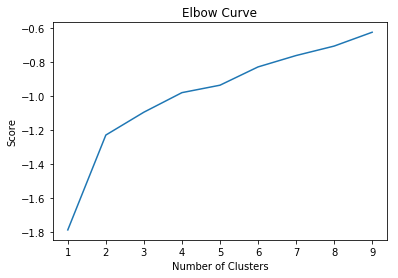

In [32]:
central_grouped_clustering = central_grouped.drop('Subzone', 1)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(central_grouped_clustering).score(central_grouped_clustering) for i in range(len(kmeans))]
score

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')

pl.show()


Setting the value of clusters to 5

In [33]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(central_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 2, 0, 4, 2, 2, 4, 0, 0], dtype=int32)

Next step is creating a new pandas data frame to merge the clusters with the top 10 most common venue

In [1]:
#central_venues_sorted.drop(columns='Cluster name', axis=0, inplace=True)

In [ ]:
#central_venues_sorted.head()

In [35]:
# add clustering labels
central_venues_sorted.insert(0, 'Cluster name', kmeans.labels_)

central_merged = central

# merge central_grouped with central to add latitude/longitude for each sub-zones
central_merged = central_merged.join(central_venues_sorted.set_index('Subzone'), on='Subzone')

central_merged.head()

,Longitude,Latitude,Subzone,Region Name,Central Area Indicator,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,103.844945,1.289751,CLARKE QUAY,CENTRAL REGION,Y,0,Japanese Restaurant,Hotel,Bar,Nightclub,Seafood Restaurant,Café,Thai Restaurant,Hotpot Restaurant,Spa,Bakery
1,103.843342,1.274116,ANSON,CENTRAL REGION,Y,0,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Café,Hotel,Bakery,Italian Restaurant,Gym / Fitness Center,Korean Restaurant,Tapas Restaurant
2,103.837635,1.293569,INSTITUTION HILL,CENTRAL REGION,Y,0,Japanese Restaurant,Hotel,Café,Coffee Shop,Wine Bar,Restaurant,Steakhouse,Yoga Studio,Burger Joint,Seafood Restaurant
3,103.859296,1.271357,STRAITS VIEW,CENTRAL REGION,Y,3,Boat or Ferry,Pier,Road,Bar,Seafood Restaurant,Government Building,Metro Station,History Museum,Snack Place,Cruise
4,103.848562,1.278497,CECIL,CENTRAL REGION,Y,0,Coffee Shop,Japanese Restaurant,Korean Restaurant,Café,Hotel,Chinese Restaurant,Restaurant,Italian Restaurant,Food Court,Sandwich Place


Visualize the created cluster in a map

In [36]:
# create map
central_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(central_merged['Latitude'], central_merged['Longitude'], central_merged['Subzone'], central_merged['Cluster name']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(central_clusters)
       
central_clusters

## Examine the resulting clusters

#### Cluster 1

In [47]:
central_merged.loc[central_merged['Cluster name'] == 0, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CLARKE QUAY,0,Japanese Restaurant,Hotel,Bar,Nightclub,Seafood Restaurant,Café,Thai Restaurant,Hotpot Restaurant,Spa,Bakery
1,ANSON,0,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Café,Hotel,Bakery,Italian Restaurant,Gym / Fitness Center,Korean Restaurant,Tapas Restaurant
2,INSTITUTION HILL,0,Japanese Restaurant,Hotel,Café,Coffee Shop,Wine Bar,Restaurant,Steakhouse,Yoga Studio,Burger Joint,Seafood Restaurant
4,CECIL,0,Coffee Shop,Japanese Restaurant,Korean Restaurant,Café,Hotel,Chinese Restaurant,Restaurant,Italian Restaurant,Food Court,Sandwich Place
5,PHILLIP,0,Chinese Restaurant,Japanese Restaurant,Café,Yoga Studio,Cocktail Bar,Italian Restaurant,Gym / Fitness Center,Korean Restaurant,Salad Place,Restaurant
6,RAFFLES PLACE,0,Chinese Restaurant,Italian Restaurant,Café,Japanese Restaurant,Coffee Shop,Hotel,Cocktail Bar,Salad Place,Gym / Fitness Center,Korean Restaurant
10,CHINA SQUARE,0,Japanese Restaurant,Cocktail Bar,Chinese Restaurant,Café,Hostel,Hotel,Wine Bar,Italian Restaurant,Korean Restaurant,Gym / Fitness Center
14,TANJONG PAGAR,0,Japanese Restaurant,Coffee Shop,Café,Bakery,Ramen Restaurant,Italian Restaurant,Cocktail Bar,Salad Place,Gym / Fitness Center,Korean Restaurant
22,MARINA SOUTH,0,Garden,Seafood Restaurant,Scenic Lookout,Park,Botanical Garden,Café,Satay Restaurant,Bridge,French Restaurant,Restaurant
23,MAXWELL,0,Japanese Restaurant,Coffee Shop,Korean Restaurant,Cocktail Bar,Bakery,Ramen Restaurant,Spanish Restaurant,Hotel,Café,Dessert Shop


If we look at the most common venues from Cluster 1, we could describe Cluster 1 as Asian Restaurant given the number of Japanese Restaurants and Chinese Restaurants.

#### Cluster 2

In [57]:
central_merged.loc[central_merged['Cluster name'] == 1, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,MACKENZIE,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Motel,Hospital,Café,Cantonese Restaurant,Music Venue,Coffee Shop,Bus Line,Bakery
17,LITTLE INDIA,1,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Hotel,Café,Hostel,Asian Restaurant,Breakfast Spot,Motel,BBQ Joint
21,FARRER PARK,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Hostel,Café,Breakfast Spot,North Indian Restaurant,Chinese Restaurant,Restaurant,Pakistani Restaurant


For Cluster 2, it could be defined as Indian and Vegan Restaurants due to the majority of these categories.

#### Cluster 3

In [58]:
central_merged.loc[central_merged['Cluster name'] == 2, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,BENCOOLEN,2,Café,Hotel,Indian Restaurant,Food Court,Sports Bar,Bakery,Chinese Restaurant,Dessert Shop,Art Gallery,Ice Cream Shop
9,BRAS BASAH,2,Hotel,Café,Japanese Restaurant,French Restaurant,Bakery,Chinese Restaurant,Ice Cream Shop,Bookstore,Shopping Mall,Movie Theater
11,BUGIS,2,Hotel,Café,Bakery,Dessert Shop,Cocktail Bar,Arts & Crafts Store,Italian Restaurant,Bookstore,Shopping Mall,Gift Shop
18,KAMPONG GLAM,2,Café,Bakery,Hotel,Restaurant,Italian Restaurant,Indonesian Restaurant,Coffee Shop,Indian Restaurant,Thai Restaurant,Cocktail Bar
19,SELEGIE,2,Café,Indian Restaurant,Hotel,Art Gallery,Chinese Restaurant,Ice Cream Shop,Yoga Studio,Playground,Park,Music Venue
20,ROCHOR CANAL,2,Café,Hotel,Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Asian Restaurant,Bakery,Hostel,Food Court,Cocktail Bar
26,ROBERTSON QUAY,2,Café,Hotel,Japanese Restaurant,Coffee Shop,Gym,Restaurant,Steakhouse,Chinese Restaurant,Yoga Studio,Salad Place
30,CITY HALL,2,Hotel,French Restaurant,Cocktail Bar,Shopping Mall,Café,Chinese Restaurant,Japanese Restaurant,Concert Hall,Lounge,Bookstore
35,LEONIE HILL,2,Fried Chicken Joint,Bakery,Yoga Studio,Spa,Hotel,Hainan Restaurant,Gym / Fitness Center,Grocery Store,Gourmet Shop,Coffee Shop
36,SUNGEI ROAD,2,Indian Restaurant,Chinese Restaurant,Café,Hotel,Hostel,Asian Restaurant,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Dim Sum Restaurant,Dessert Shop


Cluster 3 could be described as Hotel and Cafe neighbourhood.


#### Cluster 4

In [59]:
central_merged.loc[central_merged['Cluster name'] == 3, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,STRAITS VIEW,3,Boat or Ferry,Pier,Road,Bar,Seafood Restaurant,Government Building,Metro Station,History Museum,Snack Place,Cruise


Cluster 4 could be desribed as water venue.

#### Cluster 5

In [61]:
central_merged.loc[central_merged['Cluster name'] == 4, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,BAYFRONT SUBZONE,4,Boutique,Hotel,Theater,Waterfront,Noodle House,Roof Deck,Casino,Tea Room,Bridge,Italian Restaurant
13,PATERSON,4,Boutique,Japanese Restaurant,Shopping Mall,Bubble Tea Shop,Sushi Restaurant,Café,Chinese Restaurant,Cosmetics Shop,Department Store,Asian Restaurant
15,CLIFFORD PIER,4,Boutique,Waterfront,Plaza,Coffee Shop,Cocktail Bar,Japanese Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Italian Restaurant
34,SOMERSET,4,Japanese Restaurant,Hotel,Shopping Mall,Clothing Store,Wine Bar,Ramen Restaurant,Coffee Shop,Yoga Studio,Chinese Restaurant,Bubble Tea Shop
39,CAIRNHILL,4,Hotel,Boutique,Japanese Restaurant,Chinese Restaurant,Shopping Mall,Café,Asian Restaurant,Indonesian Restaurant,Bubble Tea Shop,Steakhouse
41,BOULEVARD,4,Boutique,Japanese Restaurant,Hotel,Café,Sushi Restaurant,Cosmetics Shop,Department Store,French Restaurant,Chinese Restaurant,Bakery


Cluster 5 could be described as Botique neighbourhood

#### Cluster 6

In [62]:
central_merged.loc[central_merged['Cluster name'] == 5, central_merged.columns[[2] + list(range(5, central_merged.shape[1]))]]

,Subzone,Cluster name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,ORANGE GROVE,5,Hotel,Japanese Restaurant,Chinese Restaurant,Café,French Restaurant,Yoga Studio,Burger Joint,Buffet,Boutique,Spanish Restaurant
33,ONE TREE HILL,5,Hotel,Japanese Restaurant,Korean Restaurant,Restaurant,Bar,Chinese Restaurant,Cocktail Bar,Supermarket,Deli / Bodega,Indian Restaurant
43,TANGLIN,5,Hotel,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Deli / Bodega,Steakhouse,Restaurant,Cocktail Bar,Pool,Event Space


Cluster 6 could be described as Hotel neighbourhood

## Results


Below table shows the most number of venues for each cluster as well as the count for the 1st Most Common Venue

In [52]:
cl_1=central_merged.groupby(['Cluster name', '1st Most Common Venue']).size() \
  .sort_values(ascending=False) \
  .reset_index(name='count') \
#  .drop_duplicates(subset='1st Most Common Venue')
cl_1


,Cluster name,1st Most Common Venue,count
0,0,Japanese Restaurant,8
1,2,Café,7
2,0,Chinese Restaurant,5
3,2,Hotel,4
4,4,Boutique,4
5,5,Hotel,3
6,1,Indian Restaurant,3
7,0,Coffee Shop,2
8,2,Fried Chicken Joint,1
9,2,Indian Restaurant,1


Based on the clustering above, taking cluster 1 as example, we can see that there is an opportunity to open other kinds of restaurant aside from Japanese and Chinese restaurants. Fast food or other kinds of cuisines like Mexican or middle eastern cuisine might be a good alternative to give the people more options. A convenience store is also a good opportunity given that there are a number of bars/nightclubs and other tourist attractions in the cluster.

## Discussion


There is a clear market opportunity for increasing the number of F&B outlets in the Central Area of Singapore.

Given the size of Singapore, and the number of Tourists arrivals in Singapore, which was at 18.5 Million last 2018 (as per the Singapore Tourism Board data), there are plenty of opportunities to open up food places/restaurants. The analysis done here can be expanded to include the number of Tourists arrival in Singapore and try to determine what cuisines are preferred mostly, given the country of origin of the tourists. 

I only used the sub-zones from the Central Area based on Central Area Indicator. The clustering could be done differently using the other regions in Singapore, and see how that compares with the Central Area. Also the number of clusters that I derived using the elbow curve could be changed to see how that would affect the result using K-means.

More in depth analysis can be performed using other data such as tourist data or when we look at the trend of data, that is, given a specific period of time, we observe how often the top 10 most common venues are changing.


## Conclusion

In conclusion, there is definitely a market for more food places in Singapore. More market to expand/diversify the cuisines to give people more options.

Potential business owners/investors would benefit from a similar analysis by looking at the trending venues and the number of venues available for a particular area.